In [1]:
from pprint import pprint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import defaultdict
from itertools import takewhile

In [2]:
def show_grid(x, title='Plot'):
    xs = np.zeros((3,4))
    for i in range(3):
        for j in range(4):
            xs[i,j] = x.get((i,j), 0)
    
    %matplotlib inline
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        xs, vmin=xs.min(), vmax=xs.max(), annot=True, fmt=".5f", 
        cmap="YlGnBu", annot_kws={"fontsize": 14}
    )
    ax.set_title(title, fontsize=16)
    
h = lambda x: max(0, min(x, 2))
w = lambda x: max(0, min(x, 3))

from_map = lambda p: (3-p[0], p[1]-1)
to_map   = lambda p: (3-p[0], p[1]+1)
is_good  = lambda p: 0<=p[0]<3 and 0<=p[1]<4

def dict_to_map_c(d):
    return {to_map(k): v for k, v in d.items()}

def adj(s):
    si, sj = s
    out = []
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            if is_good((si+i, sj+j)) and (si+i, sj+j) not in [(1,1), (0,3), (1,3)]:
                out += [(si+i, sj+j)]
    return out

def perp(s, a):
    i, j = s
    
    if a in ['u', 'd']:
        pos = [(i,w(j-1)), (i,w(j+1))]
        if (1,1) in pos:
            pos.remove((1,1))
            pos.append((i,j))
        return set(pos)
    
    if a in ['l', 'r']:
        pos = [(h(i-1),j), (h(i+1),j)]
        if (1,1) in pos:
            pos.remove((1,1))
            pos.append((i,j))
        return set(pos)

In [3]:
gamma = 1.0
num_iter = 1000 + 1
actions = ['u', 'd', 'l', 'r']

reserved = [(1,1), (0,3), (1,3)]

neighbours = {}
for i in range(3):
    for j in range(4):
        if (i, j) in reserved:
            neighbours[i, j] = {}
            continue
            
        u = (h(i-1), j)
        d = (h(i+1), j)
        l = (i, w(j-1))
        r = (i, w(j+1))
        
        if u == (1, 1): u = (i, j)
        if l == (1, 1): l = (i, j)
        if r == (1, 1): r = (i, j)
        if d == (1, 1): d = (i, j)
        
        neighbours[i,j] = {'u': u, 'l': l, 'r': r, 'd': d}
    

_default_reward = -0.04
rewards = {s: _default_reward for s in neighbours}
rewards[0,3] = 1
rewards[1,3] = -1

# (1-wall, 2-walls)
obs = np.array([
    [(0.1, 0.9), (0.1, 0.9), (0.9, 0.1), (0.1, 0.9)],
    [(0.1, 0.9), (0.0, 0.0), (0.9, 0.1), (0.9, 0.1)],
    [(0.1, 0.9), (0.1, 0.9), (0.9, 0.1), (0.1, 0.9)],
])


def get_states():
    s = list(neighbours.keys())
    for r in reserved:
        s.remove(r)
    return s

def get_states_no_obstacles():
    s = list(neighbours.keys())
    for r in [(1,1)]:
        s.remove(r)
    return s

def get_prob_by_sa(s, a):
    p = {}
    ps = perp(s, a) - {neighbours[s][a]}

    for s_ in ps:
        p[s_] = 0.2 / len(ps)
    
    p[neighbours[s][a]] = 0.8
    
    assert np.isclose(sum(p.values()), 1.0)
    
    return p


def get_incoming(s, a):
    d = []
    for s_ in adj(s):
        d += [(s_, v) for k, v in get_prob_by_sa(s_, a).items() if k == s]
    return d

In [4]:
# for s in neighbours:
#     if s in reserved:
#         continue
#     for a in actions:
#         print(to_map(s), a, dict_to_map_c(get_prob_by_sa(s,a)))
#     print("---")
    
# fr = from_map((1,4))
# to = from_map((1,4))

# q = defaultdict(lambda: [])
# for a in actions:
#     ha = get_prob_by_sa(fr, a)
#     q[a] += [v for k, v in ha.items() if k == to]
    
# print(to_map(fr), "->", to_map(to))
# d = dict(q)
# for a in actions:
#     print(a, d[a])

## POMDP - Belief States

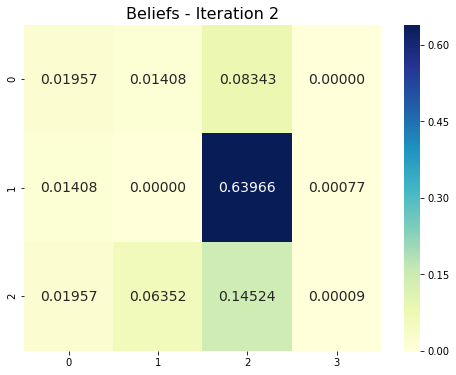

In [39]:
bnum_iter = 3
_a = 'l'
_o = 1

beliefs = {k: {s: 0 for s in get_states_no_obstacles()} for k in range(bnum_iter)}
beliefs[0] = {s: 1/9 for s in get_states_no_obstacles()}
beliefs[0][0,3] = 0
beliefs[0][1,3] = 0

for k in range(1, bnum_iter):
    for s in get_states_no_obstacles():
        
        ns = 0
        for fs, p in get_incoming(s, _a):
            ns += (p * beliefs[k-1][fs])
        
        beliefs[k][s] = obs[s][_o-1] * ns
    
    alpha = sum(beliefs[k].values())
    for s_ in beliefs[k]:
        beliefs[k][s_] = float('%.5f' % (beliefs[k][s_] / alpha))
#     assert np.isclose(sum(beliefs[k].values()), 1)
    
    
i = bnum_iter - 1
show_grid(beliefs[i], f'Beliefs - Iteration {i}')

## MDP - Value Iteration

$$V_{k+1}(s) = \max_{a}\sum_{s{}'}p(s\xrightarrow{a}s{}')(r(s\xrightarrow{a}s{}') + \gamma V_{k}(s{}'))$$

In [6]:
# values = {k: {s:0 for s in neighbours.keys()} for k in range(num_iter)}
# # values[0] = {s: rewards[s] for s in neighbours.keys()}
# policy = {k: {s:'' for s in neighbours.keys()} for k in range(num_iter)}

# for k in tqdm(range(1, num_iter)):
#     for s in get_states():
        
#         a_values = {}
#         for a in actions:
#             psa = get_prob_by_sa(s, a)
#             a_values[a] = round(sum([psa[s_n] * (rewards[s_n] + gamma * values[k-1][s_n]) for s_n in psa]), 5)

#         ma = max(a_values.values())
#         _as = sorted(a_values.items(), key=lambda x: -x[1])
#         policy[k][s] = list(takewhile(lambda x: x[1] == ma, _as))
        
#         values[k][s] = float('%.4f' % ma)

$$V_{k+1}(s) = R(s) + \gamma \max_a \sum_{s{}'}p(s\xrightarrow{a}s{}')\cdot V_{k}(s{}')$$

In [7]:
values = {k: {s:0 for s in neighbours.keys()} for k in range(num_iter)}
# values[0] = {s: rewards[s] for s in neighbours.keys()}
policy = {k: {s:'' for s in neighbours.keys()} for k in range(num_iter)}

for k in tqdm(range(1, num_iter)):
    for s in neighbours.keys():
        if s == (1,1): continue
        if s in reserved:
            values[k][s] = rewards[s]
            continue
        
        a_values = {}
        for a in actions:
            psa = get_prob_by_sa(s, a)
            a_values[a] = round(sum([psa[s_n] * values[k-1][s_n] for s_n in psa]), 5)
        
        ma = max(a_values.values())
        _as = sorted(a_values.items(), key=lambda x: -x[1])
        policy[k][s] = list(takewhile(lambda x: x[1] == ma, _as))
        
        values[k][s] = float('%.4f' % (rewards[s] + gamma * ma))

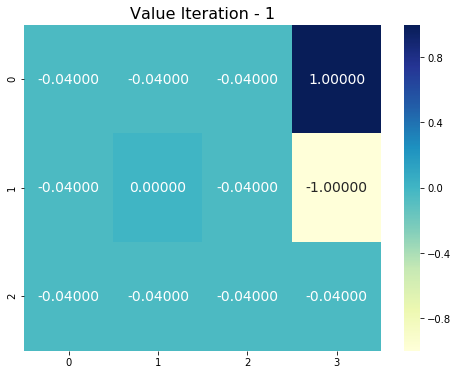

In [8]:
show_grid(values[1], 'Value Iteration - 1')

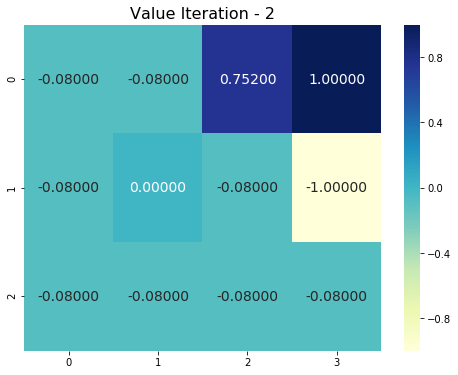

In [9]:
show_grid(values[2], 'Value Iteration - 2')

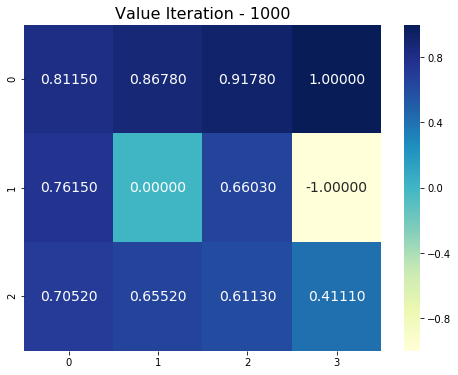

In [10]:
show_grid(values[num_iter-1], f'Value Iteration - {num_iter - 1}')

In [11]:
policy[num_iter-1]

{(0, 0): [('r', 0.85154)],
 (0, 1): [('r', 0.9078)],
 (0, 2): [('r', 0.95781)],
 (0, 3): '',
 (1, 0): [('u', 0.8015)],
 (1, 1): '',
 (1, 2): [('u', 0.70027)],
 (1, 3): '',
 (2, 0): [('u', 0.74524)],
 (2, 1): [('l', 0.6952)],
 (2, 2): [('l', 0.65132)],
 (2, 3): [('d', 0.45114)]}